<a href="https://colab.research.google.com/github/areias/slm-finetunig/blob/main/finetune_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-tuning Mistral-7b for relationship extraction

See how mistral-7b performs at relationship extraction task before and after fine-tuning on 1000 examples.

based on

[Fine-tune large models using 🤗 peft adapters, transformers & bitsandbytes](https://colab.research.google.com/drive/1jCkpikz0J2o20FBQmYmAGdiKmJGOMo-o?usp=sharing#scrollTo=WE5GJ6s7y0Xo)


[transformers meets bitsandbytes for democratzing Large Language Models (LLMs) through 4bit quantization](https://colab.research.google.com/drive/1VoYNfYDKcKRQRor98Zbf2-9VQTtGJ24k#scrollTo=jq0nX33BmfaC)

[Fine-tuning Mistral on your own data](https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb)

[Fine-tuning Large Language Models](https://learn.deeplearning.ai/finetuning-large-language-models/lesson/1/introduction)


[Ollama: Running GGUF Models from Hugging Face](https://www.markhneedham.com/blog/2023/10/18/ollama-hugging-face-gguf-models/)





## Load our fine-tuning data

In [5]:
! pip install -q peft
! pip install -q git+https://github.com/huggingface/accelerate.git
! pip install -q bitsandbytes
! pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00


In [6]:
import sys
sys.path.append('drive/My Drive/mistral-finetune/')

In [4]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
! ls drive/MyDrive/mistral-finetune/data

nyt10m_finetuning-balanced.csv	nyt10m_finetuning.csv  nyt10m_test.csv


In [8]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/mistral-finetune/data/nyt10m_finetuning-balanced.csv")

In [9]:
len(df['text'].unique())

974

In [10]:
len(df)

1452

In [11]:
df.head()

,text,h_name,t_name,relation
0,There were also performers who were born in Lo...,Johnny Rivers,Louisiana,/people/person/place_of_birth
1,"Indeed , Mr. Chávez said Sunday that he wished...",Evo Morales,Bolivia,/people/person/nationality
2,"Indeed , Mr. Chávez said Sunday that he wished...",Evo Morales,Bolivia,/people/person/place_lived
3,Analysts contrast Mr. Chávez 's success at con...,Evo Morales,Bolivia,/people/person/nationality
4,"Ecuador 's new president , Rafael Correa , joi...",Evo Morales,Bolivia,/people/person/nationality


In [12]:
df.loc[df['relation'].isna(),'relation']="None"
#df = df.loc[~df['relation'].isna()] #remove Nones


In [13]:
sentence=df['text'].unique()[31]
sentence

"Among the mourners were Queen Sofía of Spain and Bernadette Chirac , the wife of President Jacques Chirac of France , President Ilham Aliyev of Azerbaijan and young cellists , bearing witness to Mr. Rostropovich 's reputation as a man of the world whose appeal cut across class lines ."

In [14]:
df.relation.value_counts() / len(df)

/people/person/place_lived                    0.176997
/location/located_in                          0.153581
/business/person/company                      0.125344
/location/administrative_division/country     0.082645
/people/person/nationality                    0.081956
None                                          0.081956
/business/location                            0.079890
/location/country/administrative_divisions    0.066804
/people/person/place_of_birth                 0.058540
/business/company/advisors                    0.048898
/people/deceasedperson/place_of_death         0.043388
Name: relation, dtype: float64

In [15]:
df[df['text']==sentence]

,text,h_name,t_name,relation
45,Among the mourners were Queen Sofía of Spain a...,Jacques Chirac,France,/people/person/nationality
46,Among the mourners were Queen Sofía of Spain a...,Jacques Chirac,France,/people/person/place_lived
798,Among the mourners were Queen Sofía of Spain a...,Bernadette Chirac,France,/people/person/nationality
799,Among the mourners were Queen Sofía of Spain a...,Bernadette Chirac,France,/people/person/place_lived


In [16]:
len(df)

1452

In [17]:
df.text.nunique()

974

In [18]:
import numpy as np
from helper_functions import preprocess

In [19]:
# make sure works for example with no relations
data = preprocess(df)
data[400]

{'input': 'Yesterday , Mr. Sulzberger received support when Donald E. Graham , the chairman and chief executive of the Washington Post Company , urged investors to support the Times Company .',
 'output': "('Washington Post Company', '/business/company/advisors', 'Donald E. Graham'), ('Donald E. Graham', '/business/person/company', 'Washington Post Company')"}

In [20]:
# and exapmle with multiple relations
data[230]

{'input': 'The Real Estate Market Though prices have risen sharply in recent years , real estate agents and developers still talk up Port St. Lucie as a Florida bargain .',
 'output': "('St. Lucie', '/location/located_in', 'Florida')"}

In [21]:
# as well as your single relation
data[:4]

[{'input': "There were also performers who were born in Louisiana , including Lucinda Williams , Jerry Lee Lewis and Johnny Rivers , whose '' Secret Agent Man '' had a touch of bayou-country swamp-pop .",
  'output': "('Johnny Rivers', '/people/person/place_of_birth', 'Louisiana'), ('Jerry Lee Lewis', '/people/person/place_of_birth', 'Louisiana')"},
 {'input': "Indeed , Mr. Chávez said Sunday that he wished Mr. Correa the '' best of luck '' from Venezuela , where he appeared on television with President Evo Morales of Bolivia to commemorate the opening of a milk processing plant built in western Venezuela with financing from Iran .",
  'output': "('Evo Morales', '/people/person/nationality', 'Bolivia'), ('Evo Morales', '/people/person/place_lived', 'Bolivia')"},
 {'input': "Analysts contrast Mr. Chávez 's success at consolidating power in Venezuela with the troubles faced by President Evo Morales in Bolivia , where a constitution-writing assembly has been stalled by fractious delegates

In [22]:
df.relation.value_counts(dropna=False)

/people/person/place_lived                    257
/location/located_in                          223
/business/person/company                      182
/location/administrative_division/country     120
/people/person/nationality                    119
None                                          119
/business/location                            116
/location/country/administrative_divisions     97
/people/person/place_of_birth                  85
/business/company/advisors                     71
/people/deceasedperson/place_of_death          63
Name: relation, dtype: int64

In [24]:
relations = np.sort(list(df.relation.unique()))
relations = list(relations[:len(relations)-1])
relations


['/business/company/advisors',
 '/business/location',
 '/business/person/company',
 '/location/administrative_division/country',
 '/location/country/administrative_divisions',
 '/location/located_in',
 '/people/deceasedperson/place_of_death',
 '/people/person/nationality',
 '/people/person/place_lived',
 '/people/person/place_of_birth']

In [25]:
from helper_functions import formatting_func

In [26]:
print(formatting_func(data[0]))

[INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors', '/business/location', '/business/person/company', '/location/administrative_division/country', '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death', '/people/person/nationality', '/people/person/place_lived', '/people/person/place_of_birth'] 
What relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!
The given sentence is: 'There were also performers who were born in Louisiana , including Lucinda Williams , Jerry Lee Lewis and Johnny Rivers , whose '' Secret Agent Man '' had a touch of bayou-country swamp-pop .'
If none present, answer: None.
Respond with relationship triples, e.g. (head entity 1, relation 1, tail entity 1), (head entity 2, relation 2, tail entity 2), (...) 
Take care, your answer is only valid if 

## Load a quantized Mistral:instruct model

https://huggingface.co/docs/peft/main/en/developer_guides/quantization


...since PEFT methods only add extra trainable parameters, this allows you to train a quantized model with a PEFT adapter on top! Combining quantization with PEFT can be a good strategy for training even the largest models on a single GPU. For example, QLoRA is a method that quantizes a model to 4-bits and then trains it with LoRA.


bitsandbytes is a quantization library with a Transformers integration. With this integration, you can quantize a model to 8 or 4-bits and enable many other options by configuring the BitsAndBytesConfig class. For example, you can:

In [27]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

 https://huggingface.co/docs/peft/main/en/developer_guides/quantization

...For example, you can:

* set load_in_4bit=True to quantize the model to 4-bits when you load it
* set bnb_4bit_quant_type="nf4" to use a special 4-bit data type for weights initialized from a normal distribution
* set bnb_4bit_use_double_quant=True to use a nested quantization scheme to quantize the already quantized weights
* set bnb_4bit_compute_dtype=torch.bfloat16 to use bfloat16 for faster computation

In [28]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


Pass the config to the from_pretrained method.

In [29]:
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

## Load tokenizer

https://huggingface.co/docs/transformers/en/llm_tutorial#wrong-padding-side

LLMs are decoder-only architectures, meaning they continue to iterate on your input prompt. If your inputs do not have the same length, they need to be padded. Since LLMs are not trained to continue from pad tokens, your input needs to be left-padded. Make sure you also don’t forget to pass the attention mask to generate!

tokenizer.pad_token = tokenizer.eos_token  # Most LLMs don't have a pad token by default


In [30]:
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                        padding_side="left") # padding on left from brewdev notebook
tokenizer.pad_token = tokenizer.eos_token


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]



Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what self-supervised fine-tuning is.


In [31]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [32]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

## Evaluate model out of the box



In [33]:
from helper_functions import get_relations, get_tuples, get_scores

In [40]:
eval_prompt = formatting_func(data[230])
print(eval_prompt)

[INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors', '/business/location', '/business/person/company', '/location/administrative_division/country', '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death', '/people/person/nationality', '/people/person/place_lived', '/people/person/place_of_birth'] 
What relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!
The given sentence is: 'The Real Estate Market Though prices have risen sharply in recent years , real estate agents and developers still talk up Port St. Lucie as a Florida bargain .'
If none present, answer: None.
Respond with relationship triples, e.g. (head entity 1, relation 1, tail entity 1), (head entity 2, relation 2, tail entity 2), (...) 
Take care, your answer is only valid if it follows the correct format! 

In [34]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    add_bos_token=True,
)


https://huggingface.co/docs/transformers/en/generation_strategies



In [31]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    response  = eval_tokenizer.decode(model.generate(**model_input,
                    max_new_tokens=256, repetition_penalty=1.15,
                    pad_token_id=eval_tokenizer.eos_token_id)[0], skip_special_tokens=True)
    response = response.replace(eval_prompt, "")
    print(response)

 Based on the given sentence, the following relation triples can be extracted:
(Kurt Waldheim, /people/person/place_of_death, Vienna)
(Vienna, /location/located_in, Austria)
(Kurt Waldheim, /people/person/place_born, Austria)
(Kurt Waldheim, /business/person/company, United Nations)
(United Nations, /business/company/advisors, Kurt Waldheim)
(Austria, /location/country, None)
(Kurt Waldheim, /people/person/nationality, Austria)


In [39]:
response

' Based on the given sentence, the following relation triples can be extracted:\n(Kurt Waldheim, /people/person/place_of_death, Vienna)\n(Vienna, /location/located_in, Austria)\n(Kurt Waldheim, /people/person/place_born, Austria)\n(Kurt Waldheim, /business/person/company, United Nations)\n(United Nations, /business/company/advisors, Kurt Waldheim)\n(Austria, /location/country, None)\n(Kurt Waldheim, /people/person/nationality, Austria)'

In [32]:
predicted_relations = get_tuples(response.replace(eval_prompt, ""))
predicted_relations

['None']

In [33]:
#predicted_relations.append(('Evo Morales', '/people/person/nationality', 'Bolivia'))

In [34]:
#predicted_relations

In [35]:
"""import helper_functions
from importlib import reload
reload(helper_functions)"""

'import helper_functions\nfrom importlib import reload\nreload(helper_functions)'

In [38]:
expected_relations = get_relations(data[230])
expected_relations

(('Kurt Waldheim', '/people/deceasedperson/place_of_death', 'Vienna'),
 ('Kurt Waldheim', '/people/person/place_lived', 'Vienna'),
 ('Kurt Waldheim', '/business/person/company', 'United Nations'))

In [40]:
get_scores(expected_relations, ["None"])

(0.0, 0.0, 0)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
"""pip install pyarrow==11.0.0"""

'pip install pyarrow==11.0.0'

In [35]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Split DataFrame into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert back to datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)



In [36]:
# Optionally, you can remove the pandas index column
train_dataset = train_dataset.remove_columns('__index_level_0__')
test_dataset = test_dataset.remove_columns('__index_level_0__')



In [37]:
train_dataset

Dataset({
    features: ['input', 'output'],
    num_rows: 779
})

In [38]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_test_dataset = test_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

In [46]:
tokenizer.decode(tokenized_train_dataset[1]['input_ids'])

"<s> [INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors', '/business/location', '/business/person/company', '/location/administrative_division/country', '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death', '/people/person/nationality', '/people/person/place_lived', '/people/person/place_of_birth'] \nWhat relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!\nThe given sentence is: 'In 2002 , a government investigation found that Jack B. Grubman , then an analyst with Citigroup , had bragged in an e-mail message that his boss , Sanford I. Weill , had helped get his twins into the Y 's nursery school after Mr. Grubman upgraded his rating on a stock as a favor to Mr. Weill .'\nIf none present, answer: None.\nRespond with relationship triples, e.g. (head entity 1, relat

In [47]:
len(tokenized_train_dataset[1]['input_ids'])

319

In [47]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 733, 16289, 28793, 995, 460, 396, 418, 11661, 7583, 3638, 286, 395, 9040, 304, 9378, 9237, 1774, 28723, 4003, 349, 264, 1274, 302, 4628, 9378, 4514, 28747, 5936, 28748, 25443, 28748, 17998, 28748, 316, 3225, 734, 647, 7377, 25443, 28748, 2733, 647, 7377, 25443, 28748, 9701, 28748, 17998, 647, 7377, 2733, 28748, 28181, 1197, 28730, 1538, 1522, 28748, 16912, 647, 7377, 2733, 28748, 16912, 28748, 28181, 1197, 28730, 1538, 5662, 647, 7377, 2733, 28748, 1614, 601, 28730, 262, 647, 7377, 21721, 28748, 450, 358, 1293, 9701, 28748, 2912, 28730, 1009, 28730, 450, 498, 647, 7377, 21721, 28748, 9701, 28748, 28711, 1249, 472, 647, 7377, 21721, 28748, 9701, 28748, 2912, 28730, 28714, 1975, 647, 7377, 21721, 28748, 9701, 28748, 2912, 28730, 1009, 28730, 28726, 4633, 1421, 28705, 13, 3195, 3136, 297, 272, 2078, 1274, 1659, 347, 4658, 297, 272, 2078, 12271, 28804, 6746, 1864, 298, 938, 865, 3136, 477, 272, 1274, 3857, 28808, 13, 1014, 2078, 12271, 349, 28747, 464, 15602, 288, 272, 2039, 356, 8575,

974


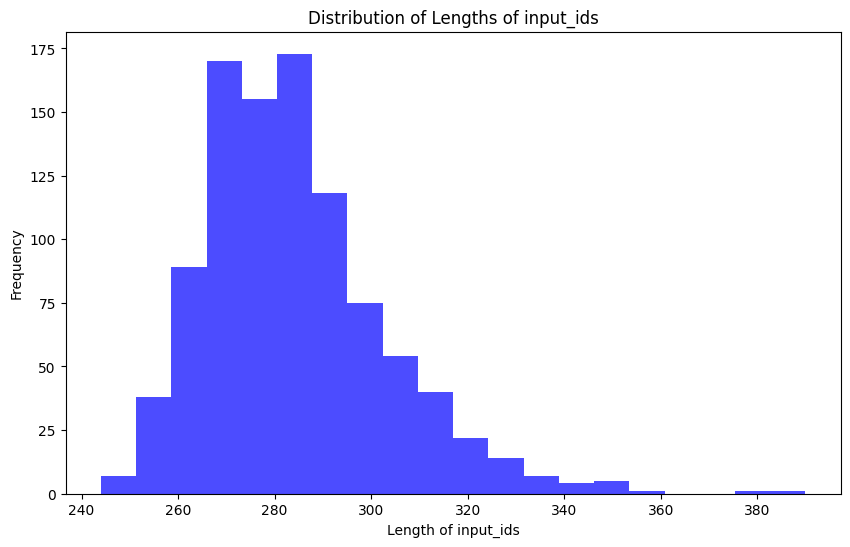

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_test_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_test_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_test_dataset)

## Set up LoRA

https://www.datacamp.com/tutorial/mastering-low-rank-adaptation-lora-enhancing-large-language-models-for-efficient-adaptation

LoRA is built on the understanding that large models inherently possess a low-dimensional structure. By leveraging low-rank matrices, LoRA adapts these models effectively. This method focuses on the core concept that significant model changes can be represented with fewer parameters, thus making the adaptation process more efficient.

First, we decompose the large weight matrices into smaller matrices using the lower-rank matrix technique, as explained above. This drastically reduces the number of trainable parameters. For a model like GPT-3, trainable parameters are reduced by 10000 times. This means instead of training 175 billion parameters, if you apply LoRA, you only have 17.5 million trainable parameters.

We do not change any parameters for a pre-trained model. Instead, only train lower-rank matrices, which happen relatively very quickly because of fewer parameters.

The weights are additive. This means for inference, we just add the weights of lower-rank matrices to pre-trained weights without any additional latency. The lower-rank matrices are very small in size as well so it is very easy to load and unload them for different tasks and different users

LoRA does not introduce any additional latency during inference. While low-rank matrices are used during training, they are merged with the original parameters for inference, ensuring no slowdown





Next, you should call the prepare_model_for_kbit_training() function to preprocess the quantized model for traininng.

In [39]:
from peft import prepare_model_for_kbit_training

#model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

https://huggingface.co/docs/peft/main/en/developer_guides/lora#qlora-style-training

However, in QLoRA, it was found that adding trainable weights to all the linear layers of a transformer model is beneficial to match full-finetuning performance. Since the list of modules to add will vary depending on the architecture, we provided a convenient shorthand : simple specify target_modules='all-linear' and let 🤗PEFT handle the rest:

https://huggingface.co/blog/4bit-transformers-bitsandbytes


## opinions on LoRA params

https://medium.com/@fartypantsham/what-rank-r-and-alpha-to-use-in-lora-in-llm-1b4f025fd133

Generally ranks bellow 32 are more like a smudges on a glass with a dirty rag. Very low values like 8 or 4 are basically just telling the model a style of how you want the output to be formatted to but not care about the details as there isn’t enough parameters to distinguish much more.

Alpha is a scaling parameter.

alpha = rank is scaling weights at 1.0

What you train in LORA weights will be then merged with the main weights of model at x 1.0

Previously people were suggesting alpha = (2 x rank), which is like yelling at your model really loud — all in order to make the newly learned weights “louder” than the model’s own. That requires a really good and large dataset, otherwise you are just amplifying nonsense.

The model knows how to speak well already, while your dataset is too small to teach (or scream at) the model any language fundamentals. Increasing alpha amplifies everything, not just the stuff you wish the model learns from it.

I would suggest rank = alpha, most of the time as your base — because it is very easily to attenuate the LORA data after the training is done if it appears to be too “loud”, overtaking the entire model.



https://www.anyscale.com/blog/fine-tuning-llms-lora-or-full-parameter-an-in-depth-analysis-with-llama-2

* Rank: 8 Choosing a higher rank for our decomposition matrices would counteract LoRA's efficiency gains. Our preliminary tests suggested minimal performance boosts when increasing the rank to, for instance, 16. As a result, we settled on a rank of 8 to maintain smaller checkpoint sizes and to avoid artificially inflating our checkpoint files.
* Alpha: 16 Alpha scales the learned weights. Existing literature, including the original LoRA paper, generally advises fixing Alpha—often at 16—rather than treating it as a tunable hyperparameter.
* Base learning rate: 1e-4
A learning rate of 1e-4 has become the standard when fine-tuning LLMs with LoRA. Although we occasionally encountered training loss instabilities, reducing the learning rate to lower values like 3e-5 proved effective in stabilizing the process—more on this will follow.

In [40]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules="all-linear",
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)


In [41]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )



Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head.


In [42]:
model = get_peft_model(model, config)

https://github.com/huggingface/transformers/blob/main/src/transformers/models/mistral/modeling_mistral.py

In [43]:
print_trainable_parameters(model)

trainable params: 83886080 || all params: 3835957248 || trainable%: 2.186835633888691


In [44]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

https://huggingface.co/docs/transformers/peft

In [45]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "mistral-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
! ls drive/MyDrive/mistral-finetune/

checkpoint-500	helper_functions.py	       mistral-finetuning-data.json
data		mistral-finetuning-data2.json  __pycache__


In [ ]:
#mkdir drive/MyDrive/mistral-finetune/runs

In [ ]:
#mkdir drive/MyDrive/mistral-finetune/runs/logs

In [46]:

project = "relation-extraction-finetune"
base_model_name = "mistral7b"
run_name = base_model_name + "-" + project + "_5" # alpha same as rank
output_dir = "drive/MyDrive/mistral-finetune/runs/" + run_name


https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft



In [47]:
output_dir

'drive/MyDrive/mistral-finetune/runs/mistral7b-relation-extraction-finetune_5'

bf16 gives error ValueError: Your setup doesn't support bf16/gpu. You need torch>=1.10, using Ampere GPU with cuda>=11.0

https://ai.google.dev/gemma/docs/lora_tuning#lora_fine-tuning

The LoRA rank determines the dimensionality of the trainable matrices that are added to the original weights of the LLM. It controls the expressiveness and precision of the fine-tuning adjustments.

A higher rank means more detailed changes are possible, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This tutorial uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html

*  train_batch_size, per_device_train_batch_size (int, optional, defaults to 8) – The batch size per PU/TPU core/CPU for training.
* learning_rate (float, optional, defaults to 5e-5) – The initial learning rate for Adam.
* warmup_steps (int, optional, defaults to 0) – Number of steps used for a linear warmup from 0 to learning_rate.




In [48]:
from datetime import datetime
import transformers

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        logging_steps=25,
        optim="paged_adamw_8bit",
        logging_dir="drive/MyDrive/mistral-finetune/runs/logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()



/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:437: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


wandb: Currently logged in as: aareias. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
25,1.167800,0.456344
50,0.436000,0.421334
75,0.410400,0.409924
100,0.444700,0.400426
125,0.424100,0.391716
150,0.398500,0.386486
175,0.422600,0.378823
200,0.374300,0.375999
225,0.377500,0.376305
250,0.397100,0.374525


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

KeyboardInterrupt: 

restart session!

## Evaluating

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import sys
sys.path.append('drive/My Drive/mistral-finetune/')

In [2]:
from helper_functions import preprocess

In [3]:
# load test data
import pandas as pd
df = pd.read_csv("./drive/MyDrive/mistral-finetune/data/nyt10m_test.csv")


In [4]:
df.loc[df['relation'].isna(),'relation']="None"

In [5]:
df.relation.value_counts()/len(df)

/people/person/place_lived                    0.229008
/location/located_in                          0.213740
None                                          0.190840
/business/person/company                      0.114504
/location/country/administrative_divisions    0.061069
/people/person/nationality                    0.061069
/location/administrative_division/country     0.053435
/business/location                            0.038168
/business/company/advisors                    0.015267
/people/deceasedperson/place_of_death         0.015267
/people/person/place_of_birth                 0.007634
Name: relation, dtype: float64

In [6]:
data = preprocess(df)

In [7]:
len(data)

100

In [8]:
data[2]

{'input': 'A1 OBITUARIES A15 Mstislav Rostropovich A cellist and conductor who was renowned as one of the great instrumentalists of the 20th century and an outspoken champion of artistic freedom in the Soviet Union during the last decades of the cold war , he was 80 and lived in Paris .',
 'output': "('Mstislav Rostropovich', '/people/person/place_lived', 'Paris')"}

In [9]:
import numpy as np
relations = np.sort(list(df.relation.unique()))
relations = list(relations[:len(relations)-1])
relations

['/business/company/advisors',
 '/business/location',
 '/business/person/company',
 '/location/administrative_division/country',
 '/location/country/administrative_divisions',
 '/location/located_in',
 '/people/deceasedperson/place_of_death',
 '/people/person/nationality',
 '/people/person/place_lived',
 '/people/person/place_of_birth']

In [ ]:
""" double checking that fits training data same categories
['/business/company/advisors',
 '/business/location',
 '/business/person/company',
 '/location/administrative_division/country',
 '/location/country/administrative_divisions',
 '/location/located_in',
 '/people/deceasedperson/place_of_death',
 '/people/person/nationality',
 '/people/person/place_lived',
 '/people/person/place_of_birth']"""

" double checking that fits training data same categories\n['/business/company/advisors',\n '/business/location',\n '/business/person/company',\n '/location/administrative_division/country',\n '/location/country/administrative_divisions',\n '/location/located_in',\n '/people/deceasedperson/place_of_death',\n '/people/person/nationality',\n '/people/person/place_lived',\n '/people/person/place_of_birth']"

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    add_bos_token=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
"""pip install accelerate"""

ERROR: Operation cancelled by user


In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
eval_prompt = formatting_func(data[2])


In [ ]:
eval_prompt

"[INST] You are an NLP expert tasked with entity and relation extraction. Here is a list of potential relation types: ['/business/company/advisors', '/business/location', '/business/person/company', '/location/administrative_division/country', '/location/country/administrative_divisions', '/location/located_in', '/people/deceasedperson/place_of_death', '/people/person/nationality', '/people/person/place_lived', '/people/person/place_of_birth'] \nWhat relations in the given list might be included in the given sentence? Make sure to use only relations from the list provided!\nThe given sentence is: 'A1 OBITUARIES A15 Mstislav Rostropovich A cellist and conductor who was renowned as one of the great instrumentalists of the 20th century and an outspoken champion of artistic freedom in the Soviet Union during the last decades of the cold war , he was 80 and lived in Paris .'\nIf none present, answer: None.\nRespond with relationship triples, e.g. (head entity 1, relation 1, tail entity 1), 

In [ ]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    response  = eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True)
    response = response.replace(eval_prompt, "")
    print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Based on the given sentence, the following relation triple can be extracted:
(Mstislav Rostropovich, /people/person/place_lived, Paris)


In [ ]:
predicted_relations = get_tuples(response)
predicted_relations

[('Mstislav Rostropovich', '/people/person/place_lived', 'Paris')]

In [ ]:
expected_relations = get_relations(data[10])
expected_relations

['None']

In [ ]:
expected_set = set(expected_relations)
expected_set

{'None'}

In [ ]:
precision, recall,f1 = get_scores(expected_relations, predicted_relations)

In [ ]:
precision,recall,f1

(1.0, 1.0, 1.0)

In [ ]:
data[0].update({'base_model' : {'predicted_relations':predicted_relations,
                                'precision': precision,
                                'recall': recall,
                                'f1': f1}})

In [ ]:
data[1:3]

[{'input': "9:30 P.M. (13) THE WILD PARROTS OF TELEGRAPH HILL -- '' Independent Lens '' follows Mark Bittner , a homeless street musician in San Francisco , as he literally goes to the birds -- and finds meaning in his life -- by taking up with a flock of wild red and green parrots .",
  'output': "('Mark Bittner', '/people/person/place_lived', 'San Francisco')"},
 {'input': 'A1 OBITUARIES A15 Mstislav Rostropovich A cellist and conductor who was renowned as one of the great instrumentalists of the 20th century and an outspoken champion of artistic freedom in the Soviet Union during the last decades of the cold war , he was 80 and lived in Paris .',
  'output': "('Mstislav Rostropovich', '/people/person/place_lived', 'Paris')"}]

In [ ]:
list(range(1,3))

[1, 2]

In [ ]:
from tqdm import tqdm

progress_bar = tqdm(total=len(data), desc='Progress')

for idx, example in zip(list(range(len(data))), data):

    eval_prompt = formatting_func(example)

    model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

    model.eval()
    with torch.no_grad():
        response  = eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256,
                                                         repetition_penalty=1.15,
                                                         pad_token_id=eval_tokenizer.eos_token_id)[0],
                                          skip_special_tokens=True)
        response = response.replace(eval_prompt, "")

    predicted_relations = get_tuples(response)

    expected_relations = get_relations(example)

    precision, recall,f1 = get_scores(expected_relations, predicted_relations)

    data[idx].update({'base_model':
                        {'response': response,
                         'predicted_relations':predicted_relations,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1}
                    })
    progress_bar.update(1)

progress_bar.close()

Progress: 100%|██████████| 100/100 [22:17<00:00, 13.38s/it]


In [ ]:
data[:4]

[{'input': '-LRB- AP -RRB- WEST VIRGINIA 67 , VILLANOVA 56 -- Frank Young scored a career-high 25 points , including eight 3-pointers , for No. 25 West Virginia -LRB- 12-1 , 2-0 -RRB- in a Big East game .',
  'output': "('Frank Young', '/people/person/place_lived', 'West Virginia')",
  'base_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. The sentence primarily describes an event (a basketball game) involving entities 'West Virginia' and 'Villanova'. However, no specific relations between these entities or other mentioned entities ('Frank Young') are explicitly stated in the sentence. Therefore, the answer would be: None.",
   'predicted_relations': 'None',
   'precision': 0.0,
   'recall': 0.0,
   'f1': 0}},
 {'input': "9:30 P.M. (13) THE WILD PARROTS OF TELEGRAPH HILL -- '' Independent Lens '' follows Mark Bittner , a homeless street musician in San Francisco , as he l

In [ ]:
import json
# Define the file path
file_path = "./mistral-finetuning-data.json"

# Save the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

print(f"Data saved to {file_path}")


Data saved to ./mistral-finetuning-data.json


In [ ]:
# Calculate average metrics
avg_precision, avg_recall, avg_f1 = calculate_average_metrics(data)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)


KeyError: 'base_model'

## load finetuned model

In [ ]:
! ls drive/MyDrive/mistral-finetune/

adapter_config.json	   optimizer.pt  rng_state.pth	trainer_state.json
adapter_model.safetensors  README.md	 scheduler.pt	training_args.bin


In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_id, add_bos_token=True, trust_remote_code=True)


In [12]:
! ls drive/MyDrive/mistral-finetune/runs/mistral7b-relation-extraction-finetune_5

checkpoint-100	checkpoint-150	checkpoint-200	checkpoint-25	checkpoint-275	checkpoint-75
checkpoint-125	checkpoint-175	checkpoint-225	checkpoint-250	checkpoint-50


In [13]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(model, "drive/MyDrive/mistral-finetune/runs/mistral7b-relation-extraction-finetune_5/checkpoint-225")


In [14]:
import json
with open("drive/MyDrive/mistral-finetune/mistral-finetuning-data.json", "r") as json_file:
    data = json.load(json_file)

In [15]:
data

[{'input': '-LRB- AP -RRB- WEST VIRGINIA 67 , VILLANOVA 56 -- Frank Young scored a career-high 25 points , including eight 3-pointers , for No. 25 West Virginia -LRB- 12-1 , 2-0 -RRB- in a Big East game .',
  'output': "('Frank Young', '/people/person/place_lived', 'West Virginia')",
  'base_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. The sentence primarily describes an event (a basketball game) involving entities 'West Virginia' and 'Villanova'. However, no specific relations between these entities or other mentioned entities ('Frank Young') are explicitly stated in the sentence. Therefore, the answer would be: None.",
   'predicted_relations': 'None',
   'precision': 0.0,
   'recall': 0.0,
   'f1': 0}},
 {'input': "9:30 P.M. (13) THE WILD PARROTS OF TELEGRAPH HILL -- '' Independent Lens '' follows Mark Bittner , a homeless street musician in San Francisco , as he l

In [16]:
import sys
sys.path.append('drive/My Drive/mistral-finetune/')

In [17]:
from helper_functions import formatting_func, get_tuples, get_relations, get_scores

In [18]:
from tqdm import tqdm

progress_bar = tqdm(total=len(data), desc='Progress')

for idx, example in zip(list(range(len(data))), data):

    eval_prompt = formatting_func(example)

    model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

    ft_model.eval()
    with torch.no_grad():
        response  = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=256,
                                                         repetition_penalty=1.15,
                                                         pad_token_id=eval_tokenizer.eos_token_id)[0],
                                          skip_special_tokens=True)
        response = response.replace(eval_prompt, "")

    predicted_relations = get_tuples(response)

    expected_relations = get_relations(example)

    precision, recall,f1 = get_scores(expected_relations, predicted_relations)

    data[idx].update({'ft_model':
                        {'response': response,
                         'predicted_relations':predicted_relations,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1}
                    })
    progress_bar.update(1)

progress_bar.close()

Progress: 100%|██████████| 100/100 [05:09<00:00,  3.09s/it]


In [19]:
data[:3]

[{'input': '-LRB- AP -RRB- WEST VIRGINIA 67 , VILLANOVA 56 -- Frank Young scored a career-high 25 points , including eight 3-pointers , for No. 25 West Virginia -LRB- 12-1 , 2-0 -RRB- in a Big East game .',
  'output': "('Frank Young', '/people/person/place_lived', 'West Virginia')",
  'base_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. The sentence primarily describes an event (a basketball game) involving entities 'West Virginia' and 'Villanova'. However, no specific relations between these entities or other mentioned entities ('Frank Young') are explicitly stated in the sentence. Therefore, the answer would be: None.",
   'predicted_relations': 'None',
   'precision': 0.0,
   'recall': 0.0,
   'f1': 0},
  'ft_model': {'response': ' None.\nIn the given sentence, there are no relation triples that can be derived from the list provided.',
   'predicted_relations': ['No

In [ ]:
! tail "drive/MyDrive/mistral-finetune/mistral-finetuning-data-nonegative.json"

In [20]:
# Define the file path
file_path = "drive/MyDrive/mistral-finetune/mistral-finetuning-data-loweralpha.json"

# Save the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

print(f"Data saved to {file_path}")


Data saved to drive/MyDrive/mistral-finetune/mistral-finetuning-data-loweralpha.json


In [ ]:
# Define the file path
import json
file_path = "drive/MyDrive/mistral-finetune/mistral-finetuning-data-balanced.json"

# Save the data to a JSON file
with open(file_path, "r") as json_file:
    data = json.load(json_file)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
for idx, entry in enumerate(data):
    if entry['output']=="None":
        print(idx)
        break

3


In [24]:
total_precision = 0.0
total_recall = 0.0
total_f1 = 0.0
total_samples = len(data)

for item in data:
    total_precision += item['ft_model']['precision']
    total_recall += item['ft_model']['recall']
    total_f1 += item['ft_model']['f1']

In [25]:
total_f1

23.0

In [26]:
for idx, item in enumerate(data):
    if item['ft_model']['precision']==1:
        print(item['ft_model']['response'])

 None.
In the given sentence, there is no triple that can be formed using relations from the list provided.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.
 None.


In [23]:
[x for x in data if (x['output'] == "None" and x['base_model']['predicted_relations'] == "None")]


[{'input': 'As the new face of the L.P.G.A. Tour , and as a star in Mexico and elsewhere , Ochoa seems to have taken to the job of being a role model .',
  'output': 'None',
  'base_model': {'response': ' Based on the given sentence, there do not seem to be any explicit relations mentioned that can be extracted using the provided list. Therefore, the answer would be: None.',
   'predicted_relations': 'None',
   'precision': 1.0,
   'recall': 1.0,
   'f1': 1.0},
  'ft_model': {'response': ' None.',
   'predicted_relations': ['None'],
   'precision': 1.0,
   'recall': 1.0,
   'f1': 1.0}},
 {'input': "Coincidentally , the movie Mr. Starkweather inspired , Terrence Malick 's '' Badlands , '' involves a flight to Saskatchewan .",
  'output': 'None',
  'base_model': {'response': " Based on the given sentence, there doesn't seem to be any clear-cut relation that can be extracted using the entities and relation types provided in the list. Therefore, the answer would be: None.",
   'predicted_r

In [22]:
[item['ft_model']['response'] for item in data if item['ft_model']['f1']!=0]

[' None.\nIn the given sentence, there is no triple that can be formed using relations from the list provided.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.']

In [21]:
def calculate_average_metrics2(data):
    total_precision = 0.0
    total_recall = 0.0
    total_f1 = 0.0
    total_samples = len(data)

    for item in data:
        total_precision += item['ft_model']['precision']
        total_recall += item['ft_model']['recall']
        total_f1 += item['ft_model']['f1']

    average_precision = total_precision / total_samples
    average_recall = total_recall / total_samples
    average_f1 = total_f1 / total_samples

    return average_precision, average_recall, average_f1

# Calculate average metrics
avg_precision, avg_recall, avg_f1 = calculate_average_metrics2(data)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)


Average Precision: 0.23
Average Recall: 0.23
Average F1-score: 0.23


In [14]:
data[24]['base_model']

{'response': ' None.\nIn this sentence, there are no explicit mentions of companies, locations, or people with specified relationships using the provided relation types. The sentence primarily discusses monetary amounts, political actions, and geographical references without specifying entities in a relational context according to the given relation types.',
 'predicted_relations': 'None',
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0}

In [27]:
data[24]['ft_model']

{'response': ' None.',
 'predicted_relations': ['None'],
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0}

In [ ]:
data[0]

{'input': '-LRB- AP -RRB- WEST VIRGINIA 67 , VILLANOVA 56 -- Frank Young scored a career-high 25 points , including eight 3-pointers , for No. 25 West Virginia -LRB- 12-1 , 2-0 -RRB- in a Big East game .',
 'output': "('Frank Young', '/people/person/place_lived', 'West Virginia')",
 'base_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. The sentence primarily describes an event (a basketball game) involving entities 'West Virginia' and 'Villanova'. However, no specific relations between these entities or other mentioned entities ('Frank Young') are explicitly stated in the sentence. Therefore, the answer would be: None.",
  'predicted_relations': 'None',
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0},
 'ft_model': {'response': " Based on the given sentence, there do not seem to be any explicit relations mentioned that can be directly extracted using the provided list. Th

https://huggingface.co/docs/transformers/en/llm_tutorial

### common pitfalls

Wrong padding side

LLMs are decoder-only architectures, meaning they continue to iterate on your input prompt. If your inputs do not have the same length, they need to be padded. Since LLMs are not trained to continue from pad tokens, your input needs to be left-padded. Make sure you also don’t forget to pass the attention mask to generate!




In [29]:

[ x['ft_model']['response'] for x in data]

[' None.\nIn the given sentence, there are no relation triples that can be derived from the list provided.',
 ' None.',
 ' None.',
 ' None.\nIn the given sentence, there is no triple that can be formed using relations from the list provided.',
 ' None.',
 ' None.',
 ' None.\nHere are some possible relation triples that might have been in the given sentence:\n(None, /business/person/company, Peter A. Chernin )\n(None, /business/person/company, Ron Meyer )\n(None, /business/person/company, Richard Cook )\n(None, /business/person/company, Brad Grey )\n(Peter A. Chernin , /business/location , None )\n(Ron Meyer , /business/location , None )\n(Richard Cook , /business/location , None )\n(Brad Grey , /business/location , None )\n(None, /business/company/advisors , Peter A. Chernin )\n(None, /business/company/advisors , Ron Meyer )\n(None, /business/company/advisors , Richard Cook )\n(None, /business/company/advisors , Brad Grey )',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' None.',
 ' No